# Sentiment analysis of Formula 1 radio messages

This is the second notebook of the task of analyzing Formula 1 radios and extracting valuable information.

For the sentiment analysis, first, we will use **nltk** with Vader. 

#### Importing necessar libraries and downloading vader lexicon

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from tqdm.notebook import tqdm

# Set styling for visualizations
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [60]:
# Download necessary NLTK resources for sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

--- 

### Loading the transcribed messages


In [61]:
data_path = "../../outputs/week4/radios_raw.csv"

radio_data = pd.read_csv(data_path)

# Display basic information

print(f"Number of transcribed radio messages: {len(radio_data)}")

radio_data.head()

Number of transcribed radio messages: 210


,driver,filename,file_path,text,duration
0,1,"driver_(1,)_belgium_radio_39.mp3","..\..\f1-strategy\data\audio\driver_(1,)\drive...",Are we following the ringer or what? You just ...,15.168
1,1,"driver_(1,)_belgium_radio_40.mp3","..\..\f1-strategy\data\audio\driver_(1,)\drive...","Okay Max, we're expecting rain in about 9 or 1...",15.576
2,1,"driver_(1,)_belgium_radio_60.mp3","..\..\f1-strategy\data\audio\driver_(1,)\drive...","Mayor Manilow, mayI X TEA ****",5.424
3,1,"driver_(1,)_belgium_radio_62.mp3","..\..\f1-strategy\data\audio\driver_(1,)\drive...",You might find this lap that you meet a little...,5.088
4,1,"driver_(1,)_belgium_radio_63.mp3","..\..\f1-strategy\data\audio\driver_(1,)\drive...",Just another two or three minutes to get throu...,5.712


--- 

### Initializing Vader sentiment analyzer

In [62]:
# Initializing the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Get the sentiment scores
def get_sentiment_scores(text):
    # I add an exception for if the radio message is empty
    if pd.isna(text) or text =="":
        return {"neg": 0 , "neu": 0, "pos": 0, "compound": 0}
    
    return sid.polarity_scores(text)

---
### Applying VADER

Moreover, I will modify our current Dataframe to add the sentiment analysis made by vader to it. Therefore, there will be *5 new columns:*

1. neg: number for specifying the ``negative`` component of the radio message.
2. pos: number for specifying the ``positive`` component of the radio message.
3. compound: the normalized, weighted composite score that represents overall sentiment of the text on a scale of -1 to 1.
4. sentiment: a final column whith the output of the sentiment. 

In [63]:
# We apply vader to each transcription

tqdm.pandas(desc = "Analyzing sentiment")
sentiment_scores = radio_data["text"].progress_apply(get_sentiment_scores)

# Convert sentiment scores to Dataframe Columns

sentiment_df = pd.DataFrame(sentiment_scores.to_list())
radio_data = pd.concat([radio_data, sentiment_df], axis = 1)



Analyzing sentiment:   0%|          | 0/210 [00:00<?, ?it/s]

In [64]:
# Adding a simple category based on compound score

def categorize_sentiment(compound):
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

In [65]:
radio_data["sentiment"] = radio_data["compound"].apply(categorize_sentiment)

# Display the updated dataframe

radio_data.head()

,driver,filename,file_path,text,duration,neg,neu,pos,compound,sentiment
0,1,"driver_(1,)_belgium_radio_39.mp3","..\..\f1-strategy\data\audio\driver_(1,)\drive...",Are we following the ringer or what? You just ...,15.168,0.059,0.691,0.250,0.7351,positive
1,1,"driver_(1,)_belgium_radio_40.mp3","..\..\f1-strategy\data\audio\driver_(1,)\drive...","Okay Max, we're expecting rain in about 9 or 1...",15.576,0.000,0.941,0.059,0.3485,positive
2,1,"driver_(1,)_belgium_radio_60.mp3","..\..\f1-strategy\data\audio\driver_(1,)\drive...","Mayor Manilow, mayI X TEA ****",5.424,0.000,1.000,0.000,0.0000,neutral
3,1,"driver_(1,)_belgium_radio_62.mp3","..\..\f1-strategy\data\audio\driver_(1,)\drive...",You might find this lap that you meet a little...,5.088,0.000,1.000,0.000,0.0000,neutral
4,1,"driver_(1,)_belgium_radio_63.mp3","..\..\f1-strategy\data\audio\driver_(1,)\drive...",Just another two or three minutes to get throu...,5.712,0.000,1.000,0.000,0.0000,neutral


---
### Analyzing sentiment distribution

In [66]:
# Analyze sentiment distribution
sentiment_counts = radio_data['sentiment'].value_counts()
print("Sentiment distribution:")
print(sentiment_counts)
print(f"Percentage of positive messages: {sentiment_counts.get('positive', 0) / len(radio_data) * 100:.2f}%")
print(f"Percentage of neutral messages: {sentiment_counts.get('neutral', 0) / len(radio_data) * 100:.2f}%")
print(f"Percentage of negative messages: {sentiment_counts.get('negative', 0) / len(radio_data) * 100:.2f}%")



Sentiment distribution:
sentiment
positive    97
neutral     81
negative    32
Name: count, dtype: int64
Percentage of positive messages: 46.19%
Percentage of neutral messages: 38.57%
Percentage of negative messages: 15.24%


#### Key observations

1. High positive sentiment. Much more than expected:

    46.19% of messages being positive are somewhat surprising for F1 team radio, whic is primarly technical and instructional in nature. However, this can be due to the end-of-race radios, where the drivers and engineers make a summary of the race.

2. Relatively low neutral percentage:

    Given that most team radio communications are tactical instructions or status updates, we would expect the neutral category to be dominant. The 38.57% neutral finding is likely an underestimation.

3. Potential VADER Limitations in F1 Context:

    Racing-specific terminology might be misclassified (e.g., "push now" being seen as positive encouragement rather than a neutral tactical instruction)

    Technical acknowledgments like "copy that, understood" might register as slightly positive.

These points prove that, when labeling the data, it will be needed to define a clear context of what is a positive or negative radio message, and maybe, eliminating the end-of-race messages, because they do not give information during the race.

C:\Users\victo\AppData\Local\Temp\ipykernel_27412\3269159944.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=radio_data, palette={'positive': 'green', 'neutral': 'gray', 'negative': 'red'})


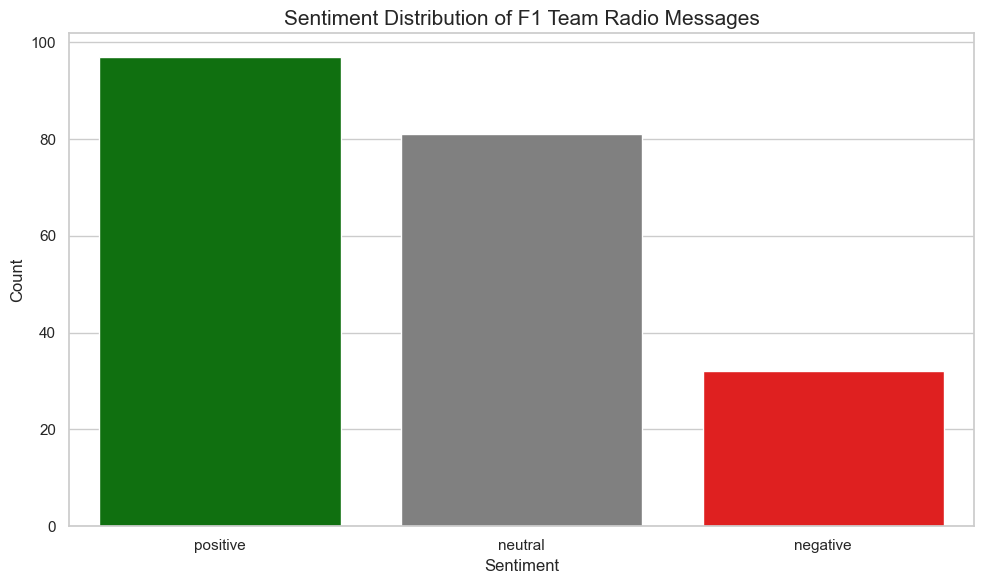

In [67]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=radio_data, palette={'positive': 'green', 'neutral': 'gray', 'negative': 'red'})
plt.title('Sentiment Distribution of F1 Team Radio Messages', fontsize=15)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

---
### Analyzing sentiment distribution by driver


<Figure size 1200x800 with 0 Axes>

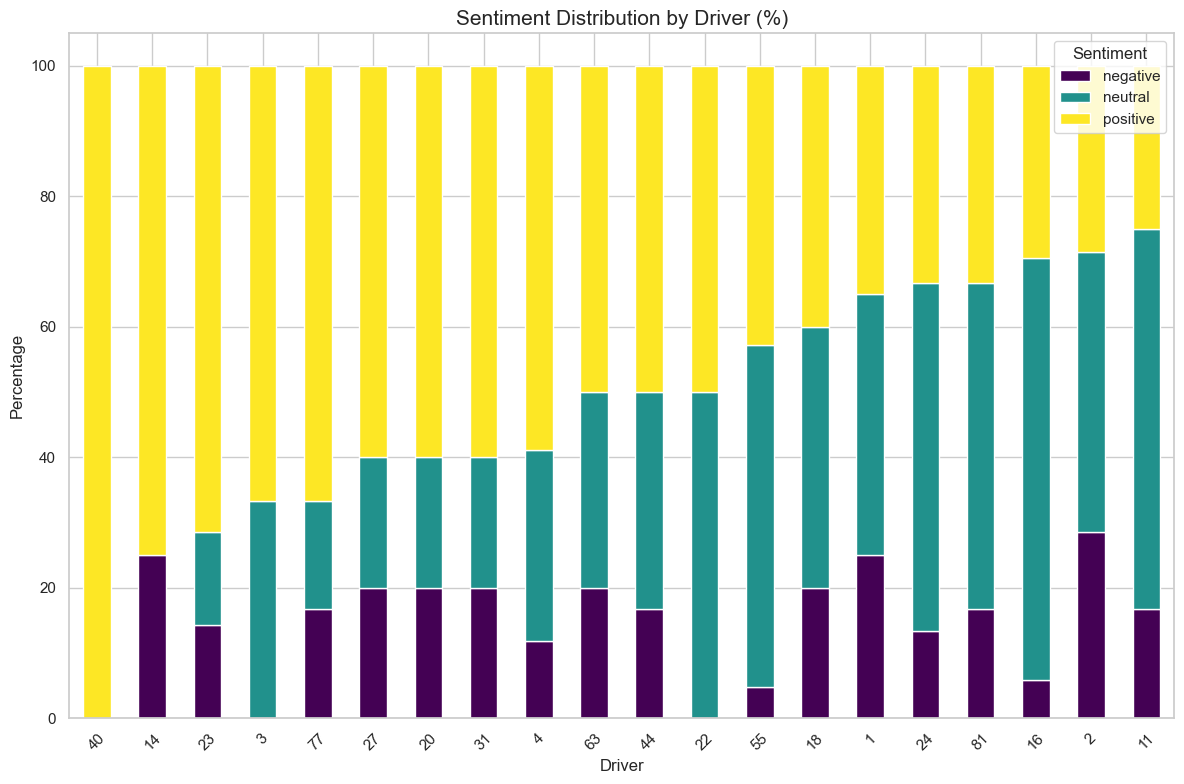

In [68]:
# Examine sentiment distribution by driver
driver_sentiment = pd.crosstab(radio_data['driver'], radio_data['sentiment'], normalize='index') * 100
driver_sentiment = driver_sentiment.sort_values(by='positive', ascending=False)

# Plot driver sentiment distribution
plt.figure(figsize=(12, 8))
driver_sentiment.plot(kind='bar', stacked=True, 
                     colormap='viridis', figsize=(12, 8))
plt.title('Sentiment Distribution by Driver (%)', fontsize=15)
plt.xlabel('Driver', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

#### Key observations

* *Extreme Variations Between Drivers*: The dramatic differences (from 100% positive for Driver 40 to mostly neutral for Driver 11) likely reflect VADER's limitations in interpreting F1-specific terminology rather than actual sentiment variations in communication styles.

* *Systematic Pattern*: The clear gradient from left (predominantly positive) to right (increasingly neutral) suggests VADER may be biased in how it processes different communication patterns, emphasizing the need for domain-specific manual labeling.


---
### Displaying examples of each sentiment category

In [69]:
# Display examples of each sentiment category
def display_examples(sentiment_type, n=10):
    examples = radio_data[radio_data['sentiment'] == sentiment_type].sort_values(
        by='compound', ascending=(sentiment_type == 'negative'))
    return examples[['driver', 'text', 'compound']].head(n)



In [70]:
print("Examples of POSITIVE messages:")
display_examples('positive')

Examples of POSITIVE messages:


,driver,text,compound
35,14,"Yes, sir. Yes, sir. Yes, sir. Yes, sir. Yes, s...",0.9962
138,40,"And that's P9 for you today. And yeah, I think...",0.9949
72,22,"Yeah well done guys, thank you. Yeah it's the ...",0.9910
207,81,"Checkered flag Oscar, well done mate, well don...",0.9867
16,1,"Yeah, I gave it all. I was pretty unlucky. Sti...",0.9851
95,24,"So we finished P12 solid race from your side, ...",0.9794
67,20,"And just, again, just fantastic. So happy for ...",0.9788
29,11,"Ok, P8 in the end there, P8. Didn't catch a br...",0.9735
111,31,"Well done mate, that was very impressive. Than...",0.9731
154,44,"Yes mate, yes, just one more lap, I would have...",0.9725


In [71]:
print("\nExamples of NEUTRAL messages:")
display_examples('neutral')


Examples of NEUTRAL messages:


,driver,text,compound
13,1,"Max, I will say it again, there is no merit at...",0.0414
2,1,"Mayor Manilow, mayI X TEA ****",0.0000
3,1,You might find this lap that you meet a little...,0.0000
5,1,So settle into standard race management now Max.,0.0000
4,1,Just another two or three minutes to get throu...,0.0000
7,1,This time I had reasonable deg in the first st...,0.0000
8,1,you,0.0000
15,1,So driving on ice. Understood.,0.0000
20,11,Some drops. There's nothing on the radar at th...,0.0000
21,11,Generally the traction is going up.,0.0000


In [72]:
print("\nExamples of NEGATIVE messages:")
display_examples('negative')


Examples of NEGATIVE messages:


,driver,text,compound
54,18,"10 knots, that's P9. So bad. No balance. So mu...",-0.8958
58,2,"Do you see the edge of the eye? Oh, left. I ca...",-0.7139
19,1,In the low speed from max steering angle to op...,-0.6705
201,77,"Okay Valtteri, no more shifts, no more shifts,...",-0.6486
143,44,"So potential rain on the radar, 20 minutes awa...",-0.6160
119,31,No! No!,-0.6103
86,24,"My foot breaks guys, come on. Really bad.",-0.5849
151,44,"7 seconds Norris. Negative, let's go for it.",-0.5719
23,11,"So no effects behind, you can exaggerate the m...",-0.5709
92,24,"Anything I can do with this break, I'm so disa...",-0.5332


---

### Saving the sentiment vader results


In [73]:
output_path = "../../outputs/week4/radios_sentiment_vader.csv"
radio_data.to_csv(output_path, index = False)
print(f"Sentiment analysis results saved to {output_path}")

Sentiment analysis results saved to ../../outputs/week4/radios_sentiment_vader.csv


---

## Making metrics for future comparison with other models

In [74]:
# Calculate metrics for future comparison with other models
metrics = {
    'model': 'VADER',
    'positive_percentage': sentiment_counts.get('positive', 0) / len(radio_data) * 100,
    'neutral_percentage': sentiment_counts.get('neutral', 0) / len(radio_data) * 100,
    'negative_percentage': sentiment_counts.get('negative', 0) / len(radio_data) * 100,
    'average_compound': radio_data['compound'].mean(),
    'std_compound': radio_data['compound'].std()
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('../../outputs/week4/sentiment_metrics_vader.csv', index=False)
print("Summary metrics:")
metrics_df

Summary metrics:


,model,positive_percentage,neutral_percentage,negative_percentage,average_compound,std_compound
0,VADER,46.190476,38.571429,15.238095,0.201061,0.41359


--- 

## Next Steps: BERT-based Sentiment Analysis

While NLTK's VADER provides a quick, lexicon-based sentiment analysis, deep learning models 
like BERT can potentially offer better performance, especially for domain-specific language 
like F1 team radio communications.

Moreover, with this sentiment analysis, we can´t extract metrics for mistakes, like false positives. For this, we´ll need to label the data.

### But first: labeling the data

I think it is a good idea to label myself the data. With the correct labeling, I can try to make a comparison between the results given by VADER and then the others.

Because of that, I´ll add the `N00_labeling_radios.ipynb`, where I will label the data.

But...

#### **When labeling data, we will exclude end-of-race messages for the following reasons:**
Why?

* Project Focus: Our model aims to support real-time strategic decision-making during races, not post-race analysis.

* Different Context: End-of-race communications follow different patterns (congratulatory, reflective) than tactical in-race messages.

* Sentiment Distortion: Including these highly emotional messages would create an unrealistic sentiment distribution compared to the strategic communications we need to analyze.

#### Therefore, in the labelling radios notebook, I´ll make this cleaning before labeling. If the dataset gets highly reduced, I may need to rerun the code with new radio messages. 
---
### Approaches for BERT-based sentiment analysis:

1. **Using pretrained BERT models**:
   - Apply a pretrained BERT model fine-tuned for sentiment analysis (e.g., from Hugging Face)
   - This approach doesn't require labeled data from our domain

2. **Fine-tuning BERT with our data**:
   - Requires manually labeling a subset of our radio messages
   - Could capture F1-specific sentiment expressions better
   - Steps:
     a. Sample a subset of messages (e.g., 100-200)
     b. Manually label them (positive, neutral, negative)
     c. Fine-tune a pretrained BERT model with these labeled examples
     d. Evaluate performance
---
## Metrics for comparison:
- Distribution of sentiment categories
- Manual evaluation of a sample of predictions
- If we create a labeled test set, we can calculate precision, recall, and F1 scores
